In [3]:
%matplotlib widget
import numpy as np

import cuml
from cuml import KMeans
from cuml.cluster import KMeans
import cudf

import sys

import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pytz
timeZone = pytz.timezone('America/Los_Angeles')

import torch

import myUtils
import torchModels
import eegUtils


# Load data

In [4]:
dataMultiply = 10**5
sFreq = 256
arrayInCompressedFile = 'arr_7'

data = np.load('/blue/gkalamangalam/jmark.ettinger/eegCompress/processedData/elimPeaksSVD001.npz')[arrayInCompressedFile]
nChannel, nSample = data.shape
data = (data * dataMultiply).astype('float32')
dataTensor = torch.tensor(data)
if torch.cuda.is_available():
    dataTensor = dataTensor.to('cuda')
    print("Data has been moved to GPU")
else:
    print("Data is on CPU")
print(data.shape)

Data has been moved to GPU
(19, 1100367)


# Load models

In [5]:
# Set parameters
modelType = 'kmeans'
loadBool = 1
modelPath = '/blue/gkalamangalam/jmark.ettinger/eegCompress/models/savedModel_04-16 00:52_-0.023.pt'
numSampleInput = 20
numSampleOutput = 1

path = '/blue/gkalamangalam/jmark.ettinger/eegCompress/processedData/kmeansModels/kmeansModel_001_block7_1stack.npz'
npzfile = np.load(path)
centroids = npzfile['arr_0']
initDict = {'kmeansInit': centroids, 'dataTensor': dataTensor, 'numSampleInput':numSampleInput}

model, dataset, loss_function = torchModels.makeModel(modelType, initDict)
model = model.to('cuda')
numSampleInput = model.numSampleInput

In [6]:
centroids = model.kmeans.float().detach().cpu().numpy()
nCentroids,_ = centroids.shape
kmeans = KMeans(n_clusters=nCentroids, init=centroids, n_init=1)

# Reconstruct the data from predictions and centroids

In [7]:
%%time

toPredict = data
predictionModel = model
kmeansModel = kmeans

model.eval()
predicted = np.zeros_like(toPredict)
predicted[:,0:numSampleInput] = toPredict[:,0:numSampleInput]

for counter in range(numSampleInput, nSample):
    if counter % 100000 == 0:
        myUtils.myPrint(counter)
        
    thisBlock = torch.unsqueeze(torch.tensor(predicted[:,counter - numSampleInput: counter]), 0).cuda()
    label = torch.tensor(data[:,counter]).cuda()
        
    thisPrediction = predictionModel(thisBlock)
    thisResidual = (label - thisPrediction).detach().cpu().numpy().transpose()
    
    index = int(kmeans.predict(np.expand_dims(thisResidual, 0))[0])
    thisCentroid = centroids[index,:]
    predicted[:,counter] = thisPrediction.detach().cpu().numpy() + thisCentroid
    

model.train()


04-19 11:49: 100000
04-19 11:52: 200000
04-19 11:55: 300000
04-19 11:58: 400000
04-19 12:00: 500000
04-19 12:03: 600000
04-19 12:06: 700000
04-19 12:09: 800000
04-19 12:12: 900000
04-19 12:15: 1000000
04-19 12:18: 1100000
CPU times: user 31min 20s, sys: 358 ms, total: 31min 20s
Wall time: 32min 16s


conv1dKmeans(
  (myNet): Sequential(
    (0): Conv1d(19, 50, kernel_size=(3,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv1d(50, 50, kernel_size=(3,), stride=(1,))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=700, out_features=19, bias=True)
  )
)

In [8]:
np.mean(np.abs(data - predicted)), np.max(np.abs(data - predicted))

(np.float32(0.4183895), np.float32(119.27998))

 current best: (0.044626124, 0.6939485)

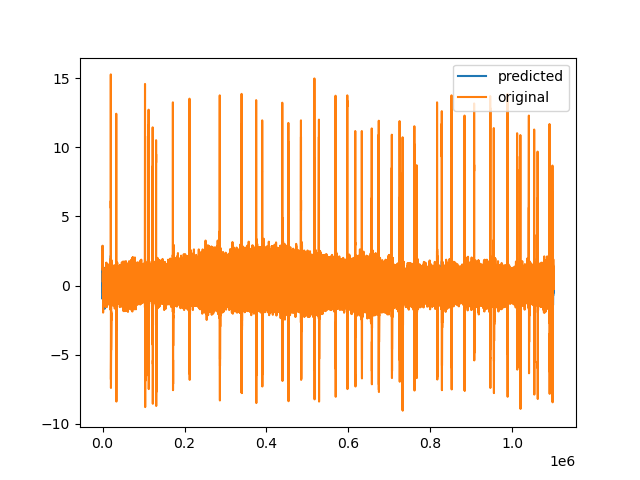

In [9]:
channel = 0

plt.figure()
plt.plot(predicted[channel,:], label='predicted')
plt.plot(data[channel,:], label='original')
residual = data - predicted
#plt.plot(residual[channel,:])
plt.legend()
plt.show()

# Save original and predicted

In [ ]:
path = '/blue/gkalamangalam/jmark.ettinger/eegCompress/processedData/origAndPredictedLossy.npz'
dataToSaveList = [data[:,0:failureIndex], predicted[:, 0:failureIndex]]
np.savez_compressed(path, *dataToSaveList)

# Scratch